<a href="https://colab.research.google.com/github/aleksandr-del/kaggle-competitions/blob/main/season_3_episode_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vector Borne Disease Prediction

![image](https://storage.googleapis.com/kaggle-datasets-images/2057766/3413944/577cbf7678c2cdb8db1e51cbb84f0a19/dataset-cover.jpg?t=2022-04-06-02-56-16)


Данные (обучающая и тестовая выборки) для этого [соревнования](https://www.kaggle.com/competitions/playground-series-s3e13/data) были сгенерированы нейронной сетью, обученной на исходных данных [Vector Borne Disease Dataset](https://www.kaggle.com/datasets/richardbernat/vector-borne-disease-prediction). Распределения признаков близко к исходным.

`Vector Borne Disease` - `трансмиссивные болезни`. Заразные болезни, возбудители которых передаются кровососущими членистоногими (насекомыми и клещами). Трансмиссивные болезни включают более 200 нозологических форм, вызываемых вирусами, бактериями, риккетсиями, простейшими и гельминтами. Часть из них передаётся только с помощью кровососущих переносчиков, часть различными способами, в том числе и трансмиссивно (например, туляремия, заражение которой происходит при укусах комаров и клещей, а также при порезах в процессе снятия шкурок с больных животных).

Результаты соревнования будут оцениваться по метрике [MPA@3](https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code/notebook). В каждом submission для каждого `id` может быть указано до трех предсказанных болезней (разделенных пробелами), и чем раньше в последовательности из трех предсказаний будет указан верный ответ, тем выше будет значение метрики.


## Загрузка и анализ данных

Импортируем необходимые библиотеки, модули и функкции:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Загрузим обучающую, тестовую выборки и шаблон файла для submission:

In [2]:
from google.colab import files

In [ ]:
files.upload()

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 /root/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c playground-series-s3e13

  0% 0.00/20.5k [00:00<?, ?B/s]
100% 20.5k/20.5k [00:00<00:00, 10.1MB/s]


Распакуем архивный файл:

In [8]:
! unzip playground-series-s3e13.zip -d data

Archive:  playground-series-s3e13.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


Сохраним обучающую выборку в переменной `df` и выведим первые 5 строк датафрейма:

In [9]:
df = pd.read_csv('/content/data/train.csv')

In [10]:
df.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


Общая информация об обучающей выборке:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 66 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     707 non-null    int64  
 1   sudden_fever           707 non-null    float64
 2   headache               707 non-null    float64
 3   mouth_bleed            707 non-null    float64
 4   nose_bleed             707 non-null    float64
 5   muscle_pain            707 non-null    float64
 6   joint_pain             707 non-null    float64
 7   vomiting               707 non-null    float64
 8   rash                   707 non-null    float64
 9   diarrhea               707 non-null    float64
 10  hypotension            707 non-null    float64
 11  pleural_effusion       707 non-null    float64
 12  ascites                707 non-null    float64
 13  gastro_bleeding        707 non-null    float64
 14  swelling               707 non-null    float64
 15  nausea

В обучающей выборке 707 наблюдений, 64 признака, метки классов в столбце `prognosis`. Пропуски отсутствуют.

В переменной `X` сохраним список признаков:

In [12]:
X = df.drop(columns=['id', 'prognosis']).columns.tolist()

Создадим словарь для преобразования строковых меток класса в числовые:

In [13]:
labels_dict = dict(zip(df['prognosis'].unique(), range(df['prognosis'].nunique())))

In [14]:
labels_dict

{'Lyme_disease': 0,
 'Tungiasis': 1,
 'Zika': 2,
 'Rift_Valley_fever': 3,
 'West_Nile_fever': 4,
 'Malaria': 5,
 'Chikungunya': 6,
 'Plague': 7,
 'Dengue': 8,
 'Yellow_Fever': 9,
 'Japanese_encephalitis': 10}

Добавим к обучающей выборке столбец с числовыми метками классов:

In [15]:
df['label'] = df['prognosis'].replace(labels_dict)

Проверим количество уникальных значений для каждого из признаков:

In [16]:
for x in X:
    print(f'У признака {x.upper()} {df[x].nunique()} уникальных значений.')

У признака SUDDEN_FEVER 2 уникальных значений.
У признака HEADACHE 2 уникальных значений.
У признака MOUTH_BLEED 2 уникальных значений.
У признака NOSE_BLEED 2 уникальных значений.
У признака MUSCLE_PAIN 2 уникальных значений.
У признака JOINT_PAIN 2 уникальных значений.
У признака VOMITING 2 уникальных значений.
У признака RASH 2 уникальных значений.
У признака DIARRHEA 2 уникальных значений.
У признака HYPOTENSION 2 уникальных значений.
У признака PLEURAL_EFFUSION 2 уникальных значений.
У признака ASCITES 2 уникальных значений.
У признака GASTRO_BLEEDING 2 уникальных значений.
У признака SWELLING 2 уникальных значений.
У признака NAUSEA 2 уникальных значений.
У признака CHILLS 2 уникальных значений.
У признака MYALGIA 2 уникальных значений.
У признака DIGESTION_TROUBLE 2 уникальных значений.
У признака FATIGUE 2 уникальных значений.
У признака SKIN_LESIONS 2 уникальных значений.
У признака STOMACH_PAIN 2 уникальных значений.
У признака ORBITAL_PAIN 2 уникальных значений.
У признака N

У всех признаков по 2 уникальных значений. Получается, что все признаки категориальные со следующими значениями: `1` - **у пациента симптом наблюдается**, `0` - **у пациента симптом отсутствует**.

Посмотрим на распределение классов в обучающей выборке:

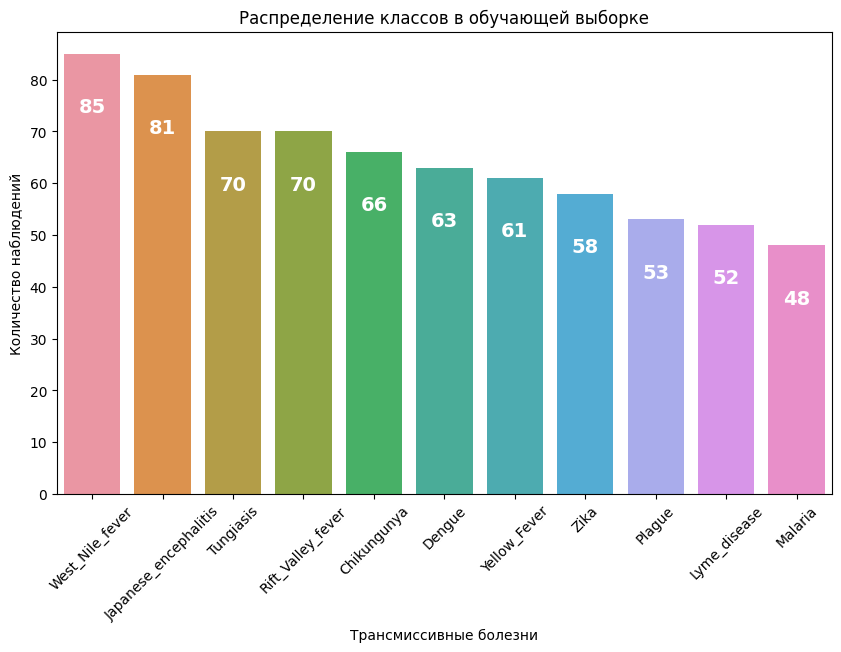

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='prognosis', 
                   data=df,
                   order=df['prognosis'].value_counts(ascending=False).index)
ax.bar_label(container=ax.containers[0],
             labels=df['prognosis'].value_counts(ascending=False).values,
             padding=-45, color='white',
             fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.ylabel('Количество наблюдений')
plt.xlabel('Трансмиссивные болезни')
plt.title('Распределение классов в обучающей выборке')
plt.show()

Посмотрим, какие симптомы больше или меньше проявляются или вовсе не проявляются у каждой болезни. Для этого посчитаем общее количество наблюдений и количество симптомов у каждого класса:

In [24]:
total = df.groupby('prognosis')[X].count().T.reset_index(names='prognosis')

In [25]:
summa = df.groupby('prognosis')[X].sum().T.reset_index(names='prognosis')

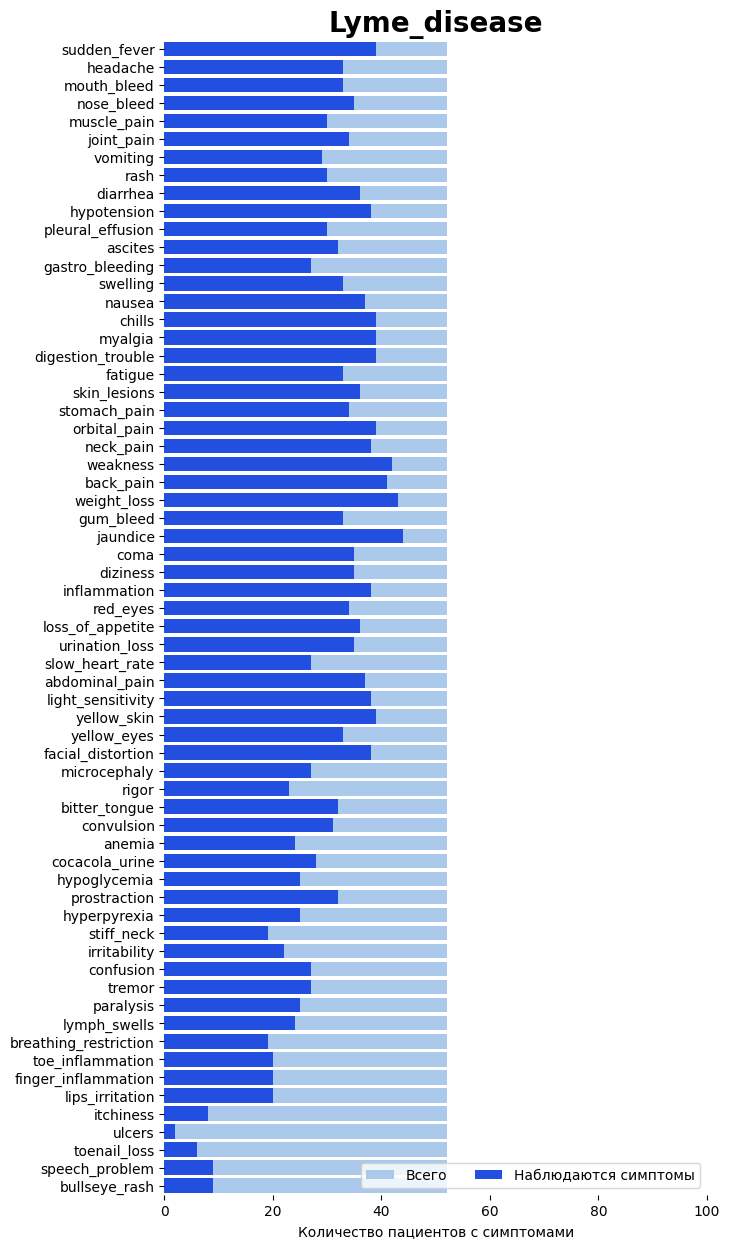

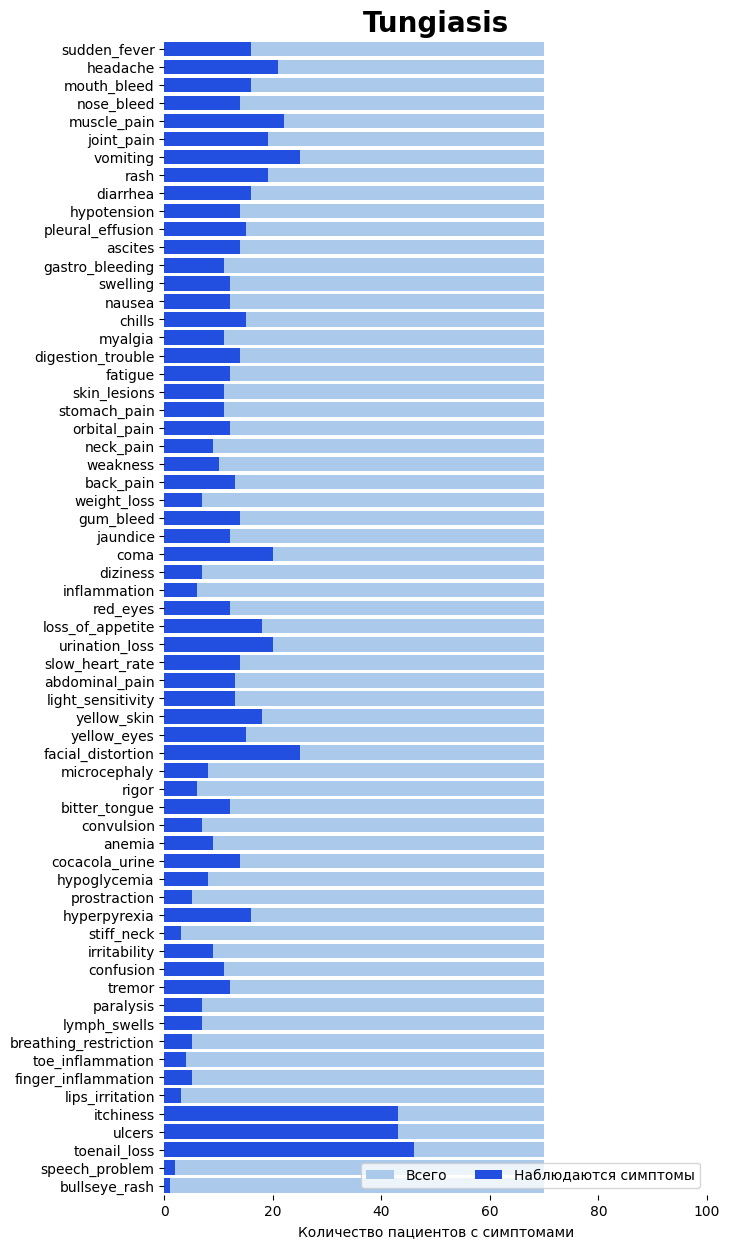

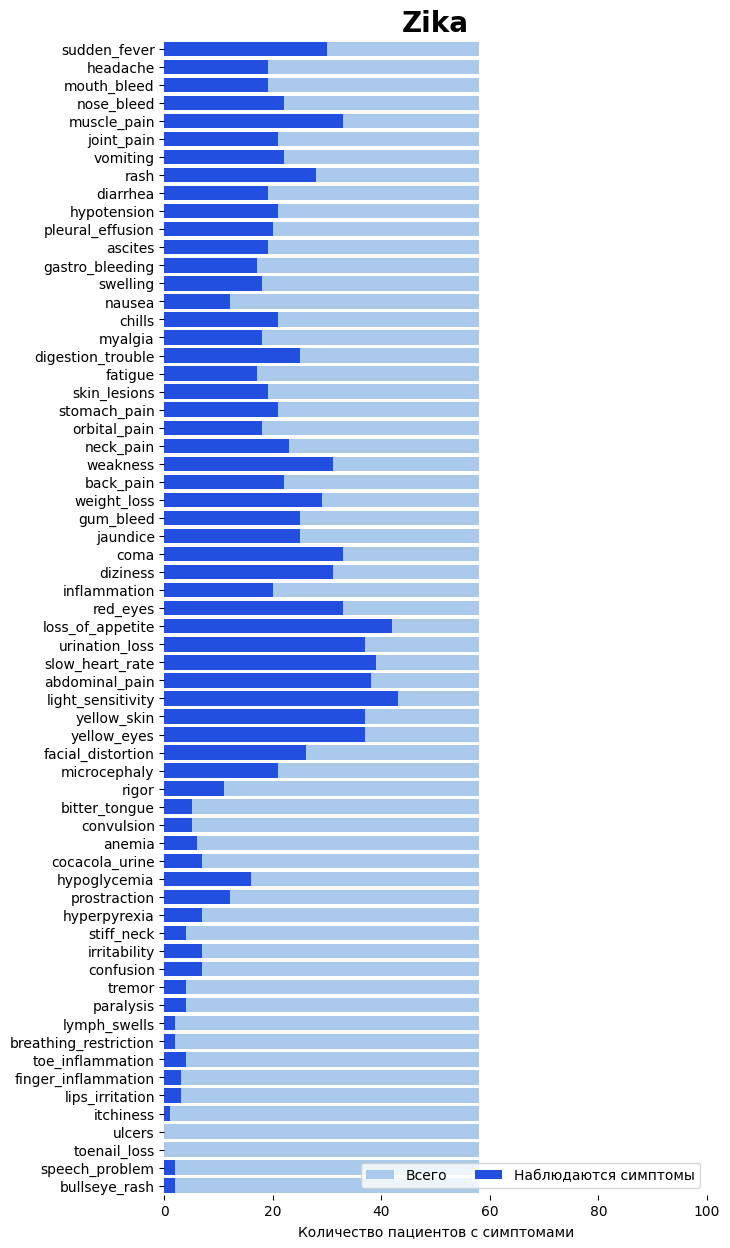

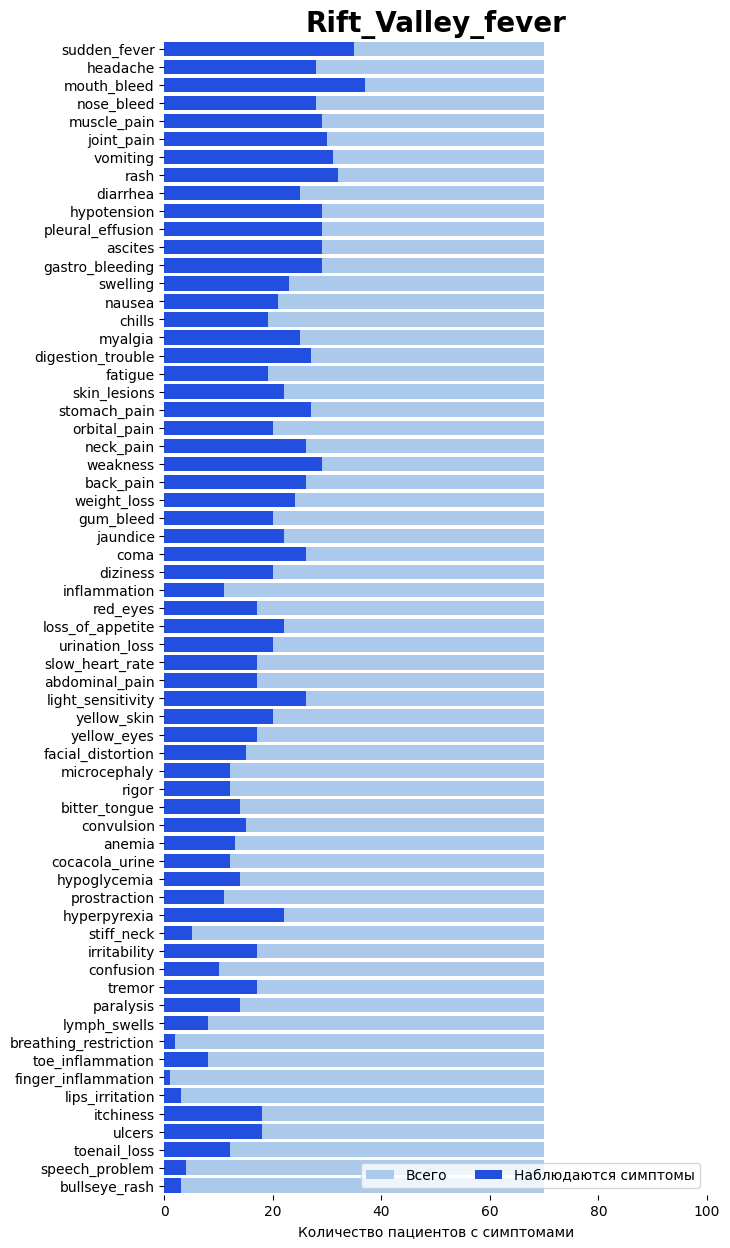

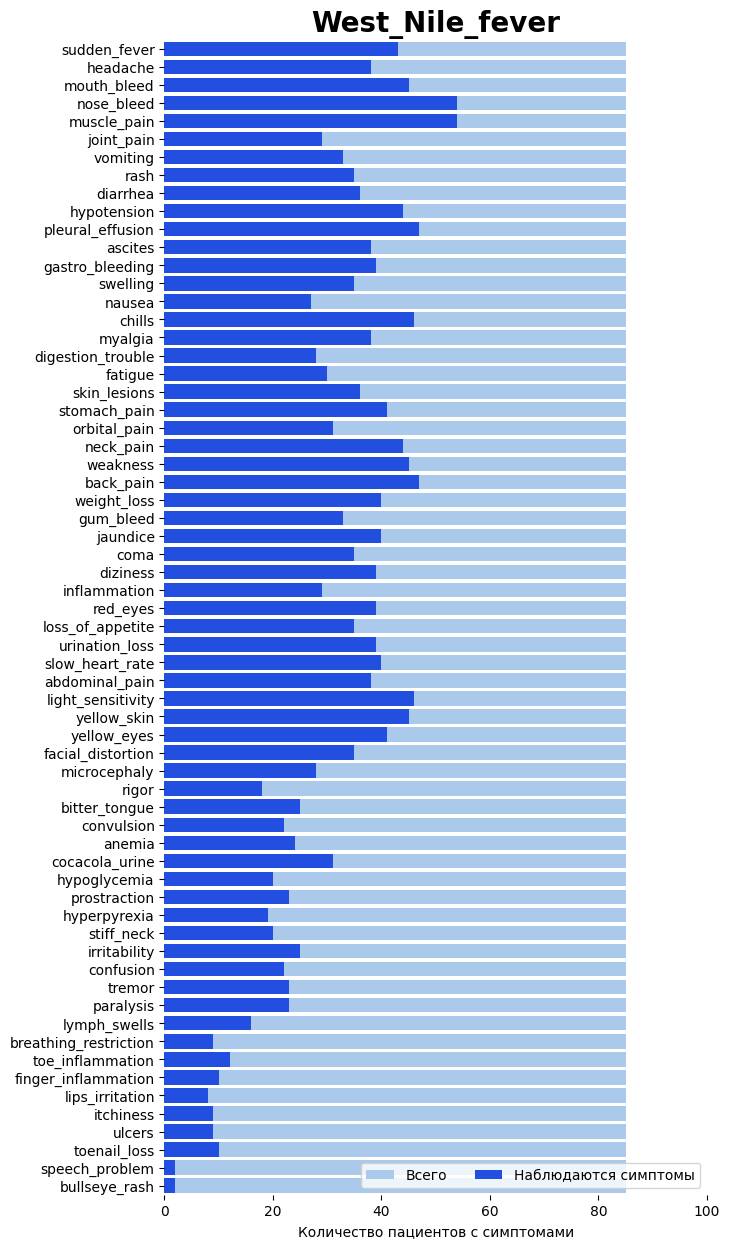

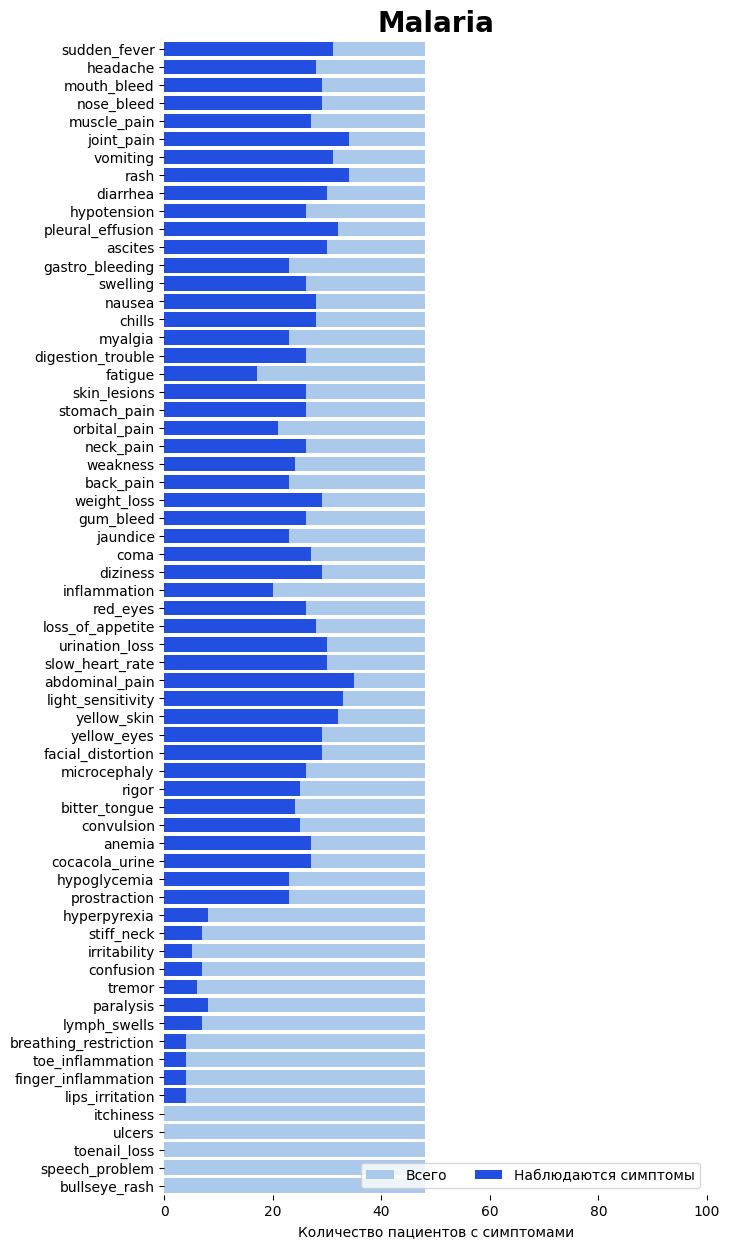

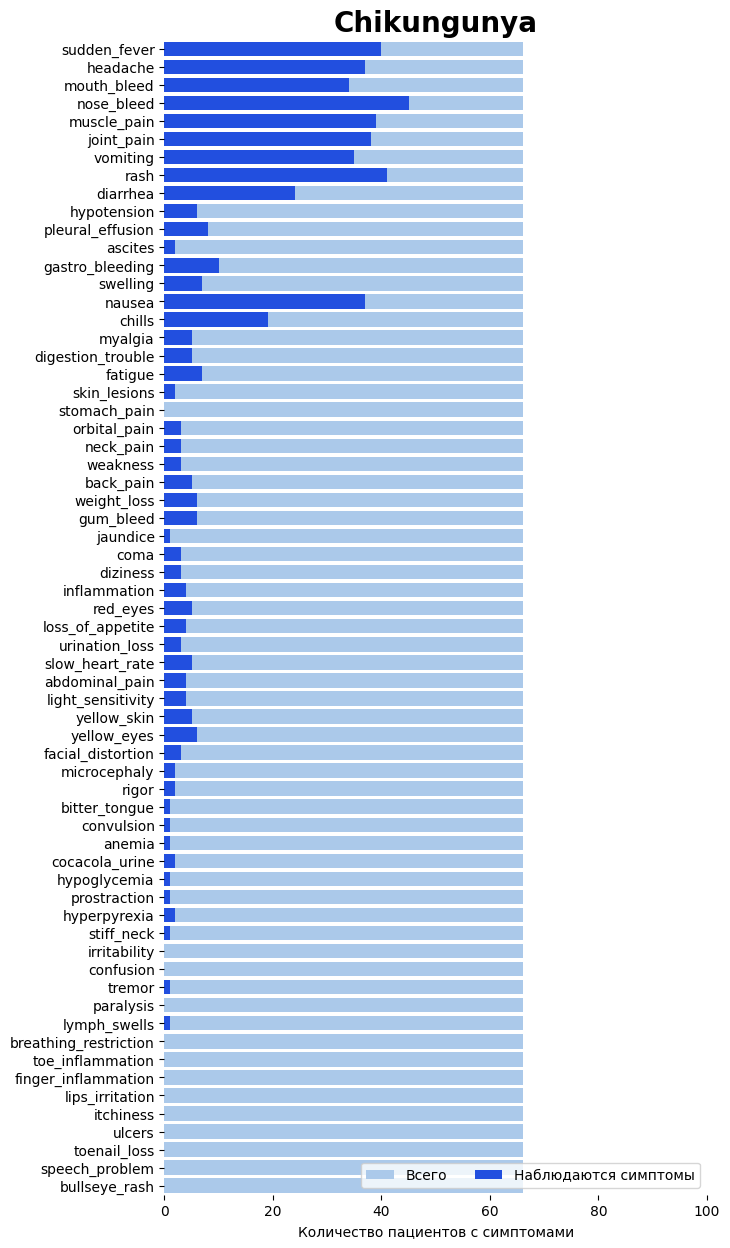

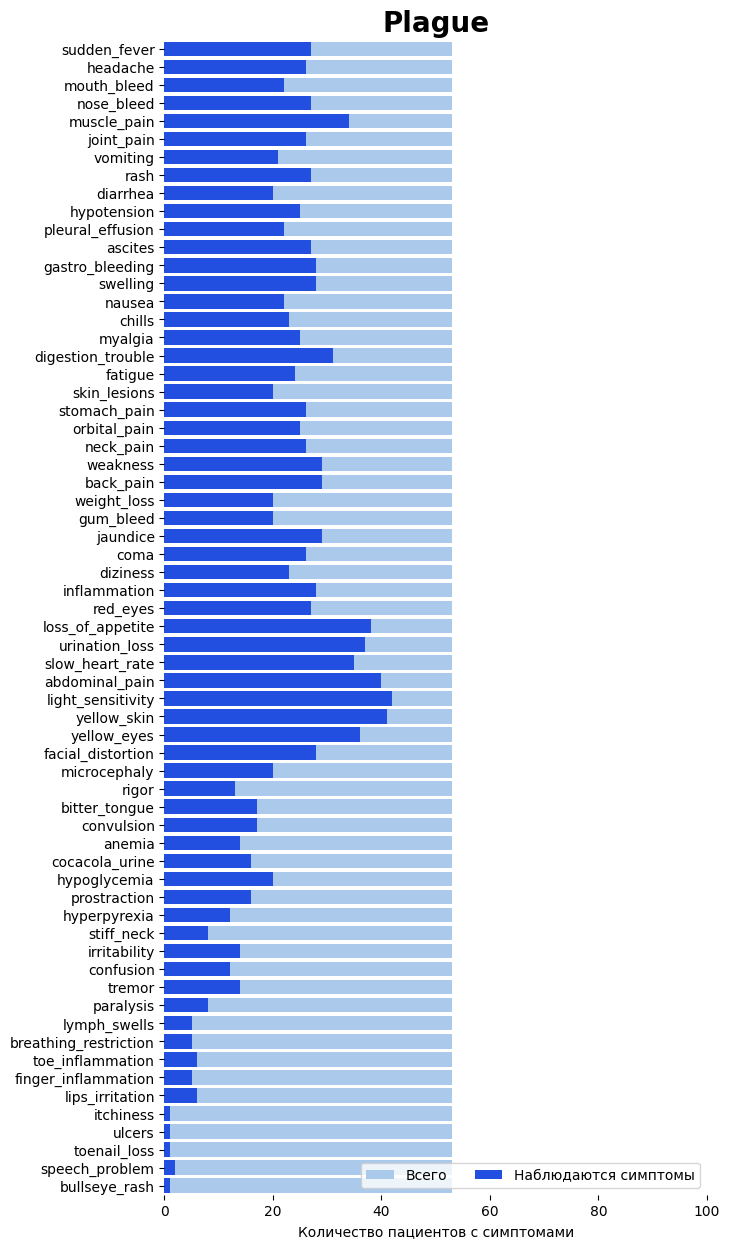

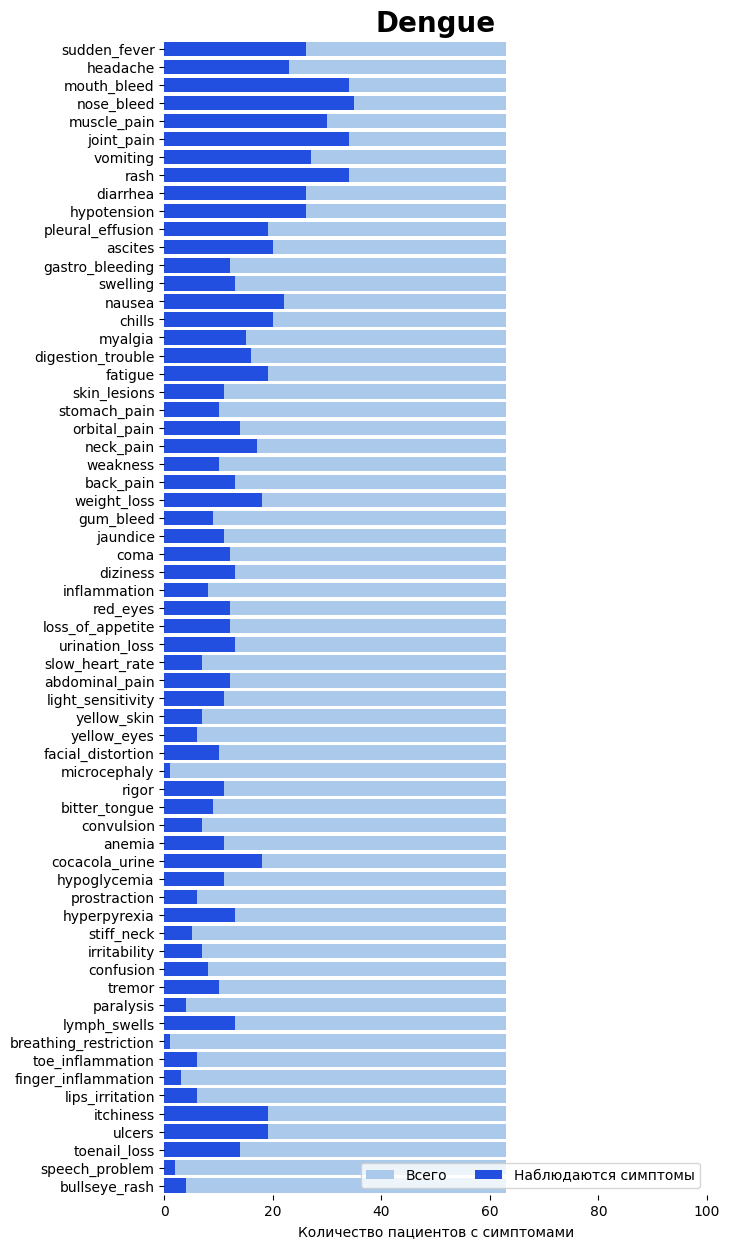

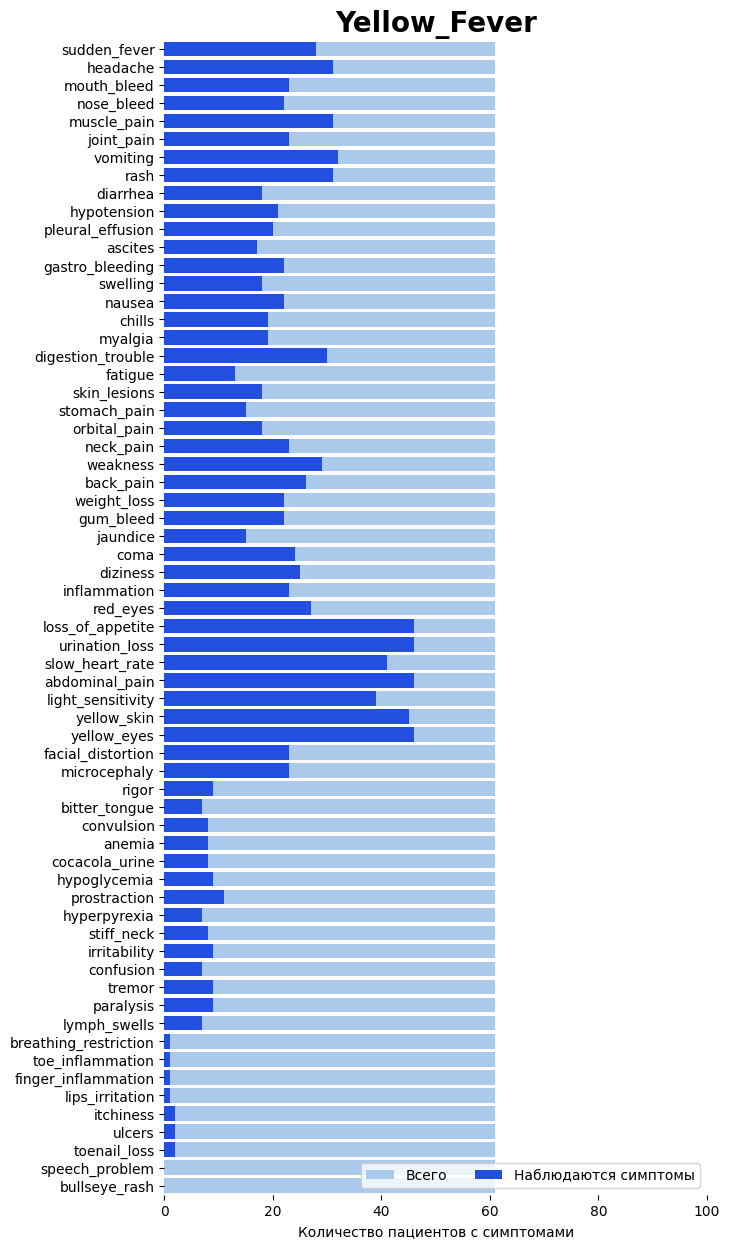

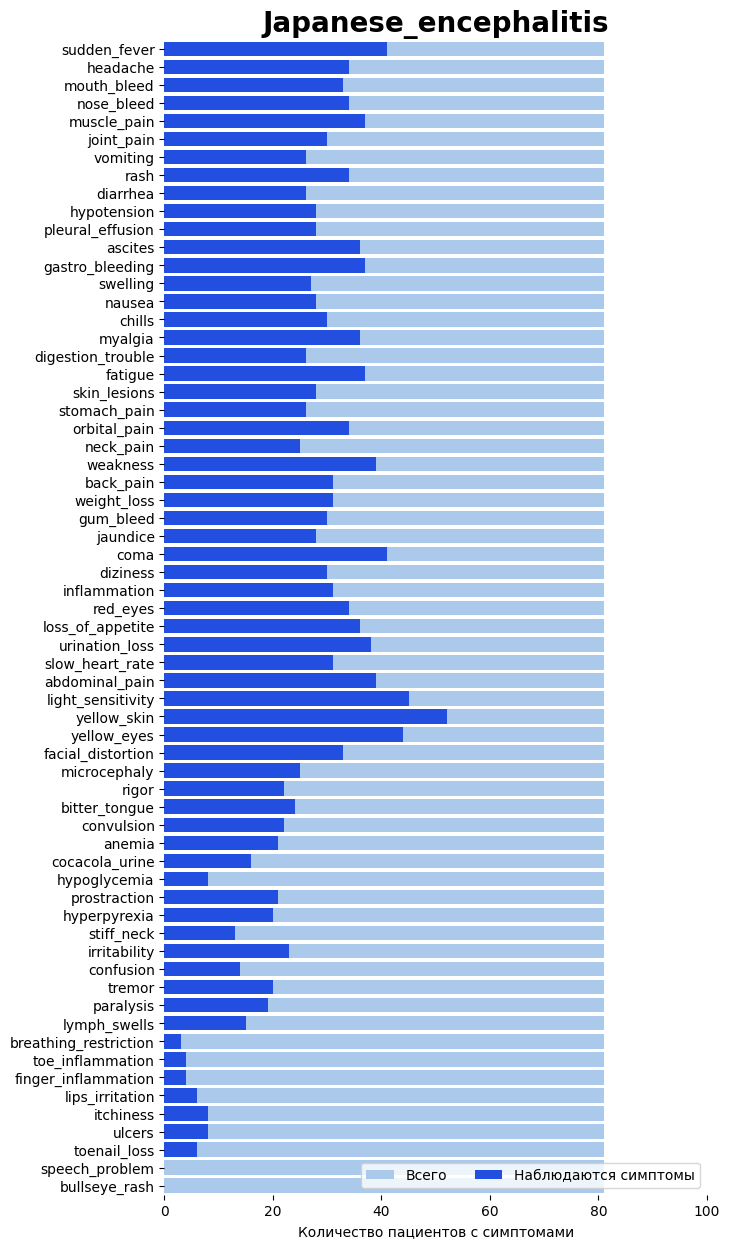

In [40]:
for i in df['prognosis'].unique():
    _, ax = plt.subplots(figsize=(7, 15))

    sns.set_color_codes('pastel')
    sns.barplot(x=i, y='prognosis', data=total, 
                label='Всего', color='b')

    sns.set_color_codes('bright')
    sns.barplot(x=i, y='prognosis', data=summa,
            label='Наблюдаются симптомы', color='b')


    ax.legend(ncol=2, loc='lower right', frameon=True)
    ax.set(xlim=(0, 100), 
           ylabel='', 
           xlabel='Количество пациентов с симптомами')
    ax.set_title(label=i, loc='center', fontdict={'fontsize': 20, 
                                                  'fontweight': 'bold'})
    sns.despine(left=True, bottom=True)
    
    plt.show()
    print()